In [27]:
# Parameters
top_folder = "../data/top_collections"


In [28]:
%load_ext autoreload
%autoreload 2


import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import random
from xai.utils.data import save_json
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import r2_score, explained_variance_score
from sklearn.model_selection import KFold


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
np.random.seed(42)
random.seed(42)

In [30]:
cuts = [f'2022-0{i}-01' for i in range(1,4)]
validation_days = 30
training_days = 30*6

periods = [
    {
        'training': {
            'start': datetime.datetime.fromisoformat(cut) - datetime.timedelta(days=training_days),
            'end': datetime.datetime.fromisoformat(cut)
        },
        'validation': {
            'start': datetime.datetime.fromisoformat(cut),
            'end': datetime.datetime.fromisoformat(cut) + datetime.timedelta(days=validation_days)
        },
        'period': cut
    }
    for cut in cuts
]

def select(df, start, end):
    w = (
        (df['timestamp'] < end) &
        (df['timestamp'] >= start)
    )
    return df[w]

In [31]:
periods

[{'training': {'start': datetime.datetime(2021, 7, 5, 0, 0),
   'end': datetime.datetime(2022, 1, 1, 0, 0)},
  'validation': {'start': datetime.datetime(2022, 1, 1, 0, 0),
   'end': datetime.datetime(2022, 1, 31, 0, 0)},
  'period': '2022-01-01'},
 {'training': {'start': datetime.datetime(2021, 8, 5, 0, 0),
   'end': datetime.datetime(2022, 2, 1, 0, 0)},
  'validation': {'start': datetime.datetime(2022, 2, 1, 0, 0),
   'end': datetime.datetime(2022, 3, 3, 0, 0)},
  'period': '2022-02-01'},
 {'training': {'start': datetime.datetime(2021, 9, 2, 0, 0),
   'end': datetime.datetime(2022, 3, 1, 0, 0)},
  'validation': {'start': datetime.datetime(2022, 3, 1, 0, 0),
   'end': datetime.datetime(2022, 3, 31, 0, 0)},
  'period': '2022-03-01'}]

In [32]:
df_t = pd.read_parquet(os.path.join(top_folder, 'asset_traits.parquet'), engine='pyarrow')
df_a = pd.read_parquet(os.path.join(top_folder, 'assets.parquet'), engine='pyarrow')

df_s = pd.read_parquet(os.path.join(top_folder, 'sales_with_trend.parquet'), engine='pyarrow')

df_s = df_s[~df_s['outlier']]
df_s = df_s.dropna(subset=["timestamp", 'price_eth'])

In [33]:
df_t_s = df_t.copy()

In [34]:
df_t_s['frequency'] = df_t_s['trait_count'] / 10000
ranks = df_t_s['trait_type'].unique()
ranks = sorted(ranks)
ranks = {
    r: i for i,r in enumerate(ranks)
}
df_t_s['rank'] = df_t_s['trait_type'].map(ranks)

In [35]:
df_features = df_t_s.set_index(['asset_id', 'trait_type'])['trait_value'].unstack()
feature_names = list(df_features.columns)

In [44]:
target = 'price_eth_scaled_100'

df = df_s.copy()
# df[target] = np.log(df[target])


df_preds = pd.DataFrame(index=df['asset_id'].unique())

df_coefs = []
cvscores = []
scores = []


one_hot_encoder = OneHotEncoder().fit(df_features)

for p in periods:
    y_training = select(df, **p['training']).groupby('asset_id')[target].median()
    y_validation = select(df, **p['validation']).groupby('asset_id')[target].median()

    # calculate cv score,
    kf = KFold(n_splits=6, shuffle=True)
    for cv_idx, (train, test) in enumerate(kf.split(y_training)):
        y_train = y_training.iloc[train]
        y_test = y_training.iloc[test]
        x_train = df_features.loc[y_train.index].copy()
        x_train_enc = one_hot_encoder.transform(x_train)

        model = ElasticNet(alpha=0.05, l1_ratio=1)
        model.fit(x_train_enc, y_train)

        for shuffle_feature in feature_names + [None]:
            x_test = df_features.loc[y_test.index].copy()
            x_train = df_features.loc[y_train.index].copy()
            if shuffle_feature is not None:
                x_train[shuffle_feature] = x_train[shuffle_feature].sample(frac=1, replace=False).values
                x_test[shuffle_feature] = x_test[shuffle_feature].sample(frac=1, replace=False).values

            x_train_enc = one_hot_encoder.transform(x_train)
            x_test_enc = one_hot_encoder.transform(x_test)

            train_pred = model.predict(x_train_enc)
            test_pred = model.predict(x_test_enc)
            this_scores = [
                dict(name='r2', set='train', value=r2_score(y_train, train_pred)),
                dict(name='r2', set='test', value=r2_score(y_test, test_pred)),
                dict(name='explained variance', set='train', value=explained_variance_score(y_train, train_pred)),
                dict(name='explained variance', set='test',  value=explained_variance_score(y_test, test_pred)),
            ]
            info = dict(cv=cv_idx, shuffle_feature=shuffle_feature, period=p["period"])
            cvscores.extend({**ts, **info} for ts in this_scores)

    x_training = df_features.loc[y_training.index]
    x_validation = df_features.loc[y_validation.index]
    x_training_enc = one_hot_encoder.transform(x_training)
    x_validation_enc = one_hot_encoder.transform(x_validation)

    model.fit(x_training_enc, y_training)
    df_coef = pd.DataFrame(
        {'feature_name': one_hot_encoder.get_feature_names_out(), 
        'coef': model.coef_, 
        'period': p["period"]})
    df_coefs.append(df_coef)

    train_pred = model.predict(x_training_enc)
    val_pred = model.predict(x_validation_enc)

    this_scores = [
        dict(name='r2', set='train', value=r2_score(y_training, train_pred)),
        dict(name='r2', set='validation', value=r2_score(y_validation, val_pred)),
        dict(name='explained variance', set='train', value=explained_variance_score(y_training, train_pred)),
        dict(name='explained variance', set='validation',  value=explained_variance_score(y_validation, val_pred)),
    ]
    info = dict(period=p["period"])
    scores.extend({**ts, **info} for ts in this_scores)

    df_preds[f'train_pred_{p["period"]}'] = pd.Series(train_pred, index=y_training.index)
    df_preds[f'val_pred_{p["period"]}'] = pd.Series(val_pred, index=y_validation.index)
    df_preds[f'train_true_{p["period"]}'] = y_training
    df_preds[f'val_true_{p["period"]}'] = y_validation
df_coefs = pd.concat(df_coefs)

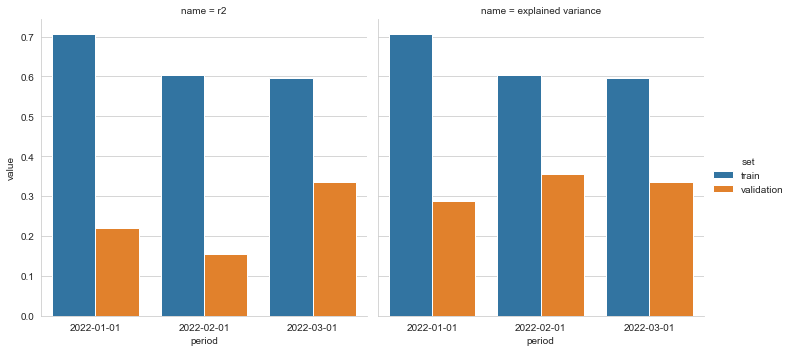

In [45]:
scores_df = pd.DataFrame.from_records(scores)
sns.set_style('whitegrid')
sns.catplot(data=scores_df, y='value', x='period', hue='set', col='name', kind='bar')

In [46]:
cvscores_df = pd.DataFrame.from_records(cvscores)
cvscores_df_no_sf = cvscores_df[cvscores_df['shuffle_feature'].isnull()]
cvscores_df_sf = cvscores_df[~cvscores_df['shuffle_feature'].isnull()]

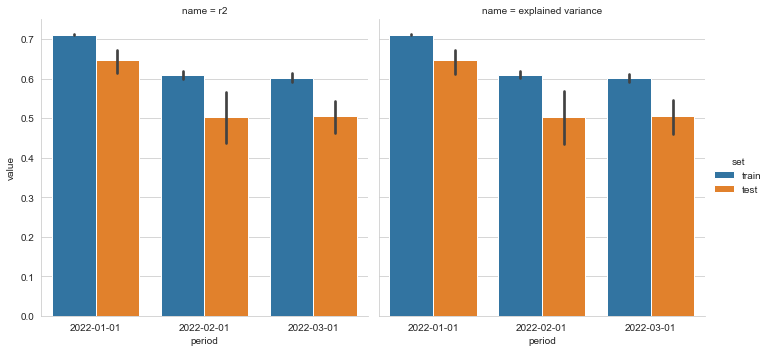

In [47]:
sns.set_style('whitegrid')
sns.catplot(data=cvscores_df_no_sf, y='value', x='period', hue='set', col='name', kind='bar')

In [49]:
shuffle_df = cvscores_df_sf.merge(cvscores_df_no_sf.drop(columns=['shuffle_feature']), on=['name', 'set', 'cv', 'period'], suffixes=('_shuffled', ''))
shuffle_df['diff'] = shuffle_df['value_shuffled'] - shuffle_df['value']
shuffle_df.head()

,name,set,value_shuffled,cv,shuffle_feature,period,value,diff
0,r2,train,0.711007,0,Background,2022-01-01,0.711579,-0.000573
1,r2,train,0.560228,0,Clothes,2022-01-01,0.711579,-0.151351
2,r2,train,0.662263,0,Earring,2022-01-01,0.711579,-0.049316
3,r2,train,0.410548,0,Eyes,2022-01-01,0.711579,-0.301032
4,r2,train,0.485763,0,Fur,2022-01-01,0.711579,-0.225817


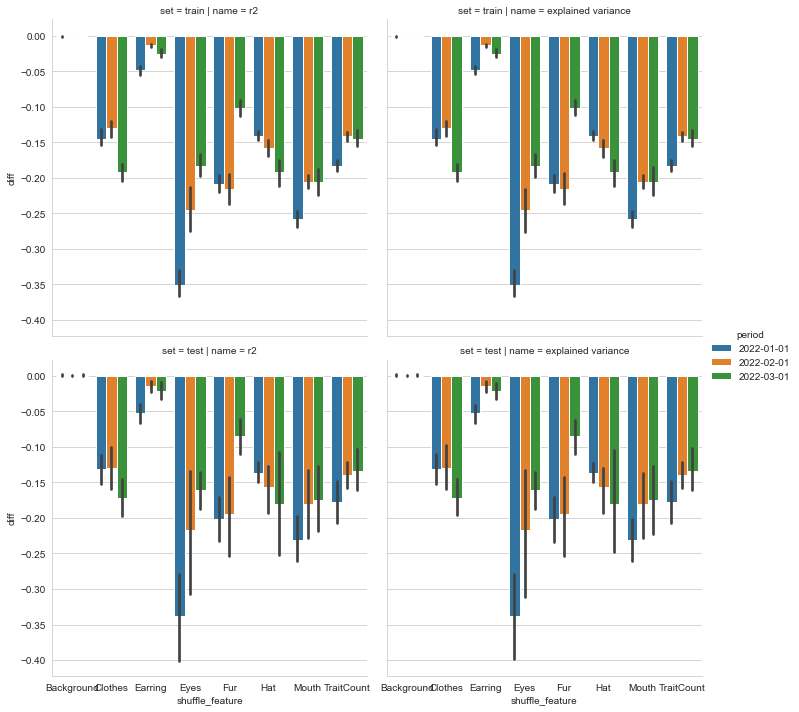

In [50]:
g = sns.catplot(data=shuffle_df, y='diff', x='shuffle_feature', hue='period', row='set', col='name', kind='bar')
g.savefig('shuffle_performance.png')

In [42]:
w = (
    (shuffle_df['period'] == '2022-03-01') &
    (shuffle_df['set'] == 'test')
)

shuffle_mean = shuffle_df[shuffle_df['period'] == '2022-03-01'].groupby(['name','shuffle_feature'])['diff'].mean()

shuffle_mean.to_csv('shuffle_mean.csv')


In [43]:
df_coefs = df_coefs.merge(df_t[['trait_id', 'trait_type', 'trait_value']].drop_duplicates())
df_coefs

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [ ]:
(df_coefs[df_coefs['period'] == '2022-03-01']['coef'] > 0.001).mean()

0.38372093023255816

In [ ]:
df_preds.head()

,train_pred_2022-01-01,val_pred_2022-01-01,train_true_2022-01-01,val_true_2022-01-01,train_pred_2022-02-01,val_pred_2022-02-01,train_true_2022-02-01,val_true_2022-02-01,train_pred_2022-03-01,val_pred_2022-03-01,train_true_2022-03-01,val_true_2022-03-01
22646197,111.811598,NaN,130.689431,NaN,113.405074,NaN,130.689431,NaN,116.386406,NaN,130.689431,NaN
22646208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22646211,177.850144,NaN,194.014151,NaN,173.553161,NaN,194.014151,NaN,157.521025,NaN,194.014151,NaN
22646214,133.436009,NaN,218.704762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22646220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.00519,NaN,118.599614


<AxesSubplot:xlabel='val_pred_2022-03-01', ylabel='val_true_2022-03-01'>

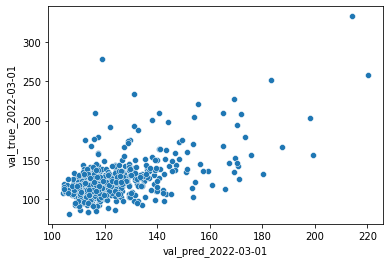

In [ ]:
sns.scatterplot(data=df_preds, x='val_pred_2022-03-01', y='val_true_2022-03-01')

In [ ]:
df_at = df_t_s.groupby('asset_id')[
    ['trait_type', 'trait_value', 'trait_count', 'rarity_score', 'frequency', 'rank']].apply(lambda df: df.to_dict(orient='records'))

df_aa = df_a.set_index('asset_id')[
    ['token_id', 'collection', 'image_url', 'image_preview_url', 'image_thumbnail_url']]

df = df_aa.copy()
df['traits'] = df_at
df['history_eth'] = df_preds['train_true_2022-03-01']
df['sales_eth'] = df_preds['val_true_2022-03-01']
df['pred_eth'] = df_preds['val_pred_2022-03-01']

df = df[~(df['history_eth'].isna() & df['sales_eth'].isna())]

df_sales = df.copy()

df[['history_eth','sales_eth','pred_eth']] = df[['history_eth','sales_eth','pred_eth']].fillna(-1.)

save_json(df.to_dict(orient='records'), os.path.join(top_folder, 'bayc_2022-03-01.json'))

In [ ]:
df_asset_coefs = df_coefs[df_coefs['period'] == '2022-03-01'] \
    .merge(df_t_s[['asset_id','trait_id']]) \
    .merge(df_a[['asset_id', 'token_id']]) \
    .merge(df_sales[['token_id', 'history_eth', 'sales_eth', 'pred_eth']])[['token_id', 'trait_type', 'trait_value', 'coef', 'history_eth', 'sales_eth', 'pred_eth']] \

df_asset_coefs.to_csv(os.path.join(top_folder, 'bayc_asset_coefficients_2022-03-01.csv'))

In [ ]:
df_asset_coefs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20273 entries, 0 to 20272
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   token_id     20273 non-null  object 
 1   trait_type   20273 non-null  object 
 2   trait_value  20273 non-null  object 
 3   coef         20273 non-null  float64
 4   history_eth  18259 non-null  float64
 5   sales_eth    3727 non-null   float64
 6   pred_eth     3727 non-null   float64
dtypes: float64(4), object(3)
memory usage: 1.2+ MB


In [ ]:
df_coefs[df_coefs['period'] == '2022-03-01'][['trait_type', 'trait_value','coef', ]].to_csv(os.path.join(top_folder, 'bayc_coefficients_2022-03-01.csv'))